In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/ 

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [2]:
cd lag-llama 

/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/benchmarks/stage_2_all_strategies/lag-llama


/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/lag_llama_venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
pip install -r requirements.txt --quiet 


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir weights/

Ignored metadata for 'lag-llama.ckpt' (outdated). Will re-compute hash.
weights/lag-llama.ckpt


In [5]:
pip install yfinance --quiet


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install peft


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10132/3178169290.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 


Sliding Window Forecast Metrics:
MAE: 73.2023
MSE: 7997.3595
RMSE: 89.4280
MAPE: 1.6379
SMAPE: 1.6289
MASE: N/A


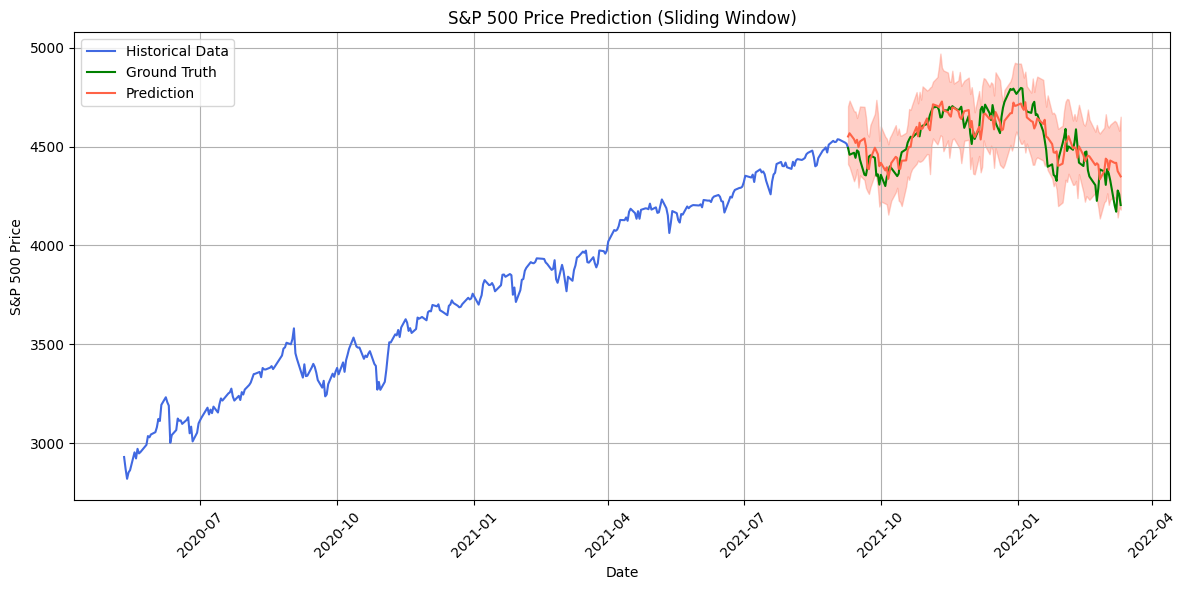

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily
from utils_snp.metrics import calculate_metrics

CONTEXT_WINDOW = 336
FORECAST_STEPS = 128 # number of one-step forecast to make

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.mps.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_single_forecast(context_data, start_date):
    """Generate a single one-step forecast"""
    # Ensure context_data is 1D
    context_data = np.asarray(context_data).flatten()
    
    # Create ListDataset for the current context window
    dataset = ListDataset(
        [{"start": start_date, "target": context_data}],
        freq="1d"
    )
    
    # Generate forecast
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,  # One-step forecast
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    
    # Extract quantiles
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]  # Return single values instead of arrays

def generate_sliding_window_forecasts(data, start_idx):
    """Fixed sliding window implementation"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    for i in range(FORECAST_STEPS):
        current_idx = start_idx + i
        
        # Get context window with exact CONTEXT_WINDOW elements
        context_start = current_idx - CONTEXT_WINDOW
        context_data = data['Close'].iloc[context_start:current_idx].to_numpy()
        context_start_date = data['Date'].iloc[context_start]
        
        # print(f"Forecast date: {data['Date'].iloc[current_idx]}")
        # print(f"Context window: {data['Date'].iloc[context_start]} to {data['Date'].iloc[current_idx - 1]}")
        # print(f"Elements in window: {len(context_data)}\n")
        
        # Validate window size
        if len(context_data) != CONTEXT_WINDOW:
            raise ValueError(f"Invalid context window size: {len(context_data)}")
        
        # Generate forecast
        low, median, high = generate_single_forecast(context_data, context_start_date)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx])
    
    return all_forecasts

def plot_forecast_with_sliding_window(data, start_idx, forecasts):
    """Fixed visualization"""
    plt.figure(figsize=(12, 6))
    
    # Plot historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'], color='royalblue', label='Historical Data')
    
    # Plot actual prices
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], color='green', label='Ground Truth')
    
    # Plot forecasts
    plt.plot(forecasts['dates'], forecasts['median'], color='tomato', label='Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction (Sliding Window)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_sliding_window_metrics(actual_values, predicted_values):
    """Calculate metrics for sliding window predictions"""
    metrics = calculate_metrics(
        actual_values,
        predicted_values,
        insample=None
    )
    return metrics

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Generate forecasts using sliding window
forecasts = generate_sliding_window_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx + 1:start_idx + FORECAST_STEPS + 1].values
metrics = calculate_sliding_window_metrics(actual_values, forecasts['median'])

# Print metrics
print("\nSliding Window Forecast Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot results
plot_forecast_with_sliding_window(sp500_d, start_idx, forecasts)

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10132/1040396044.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 


Recursive Forecast Metrics:
MAE: 327.4757
MSE: 174653.9819
RMSE: 417.9162
MAPE: 7.4122
SMAPE: 6.9873
MASE: N/A


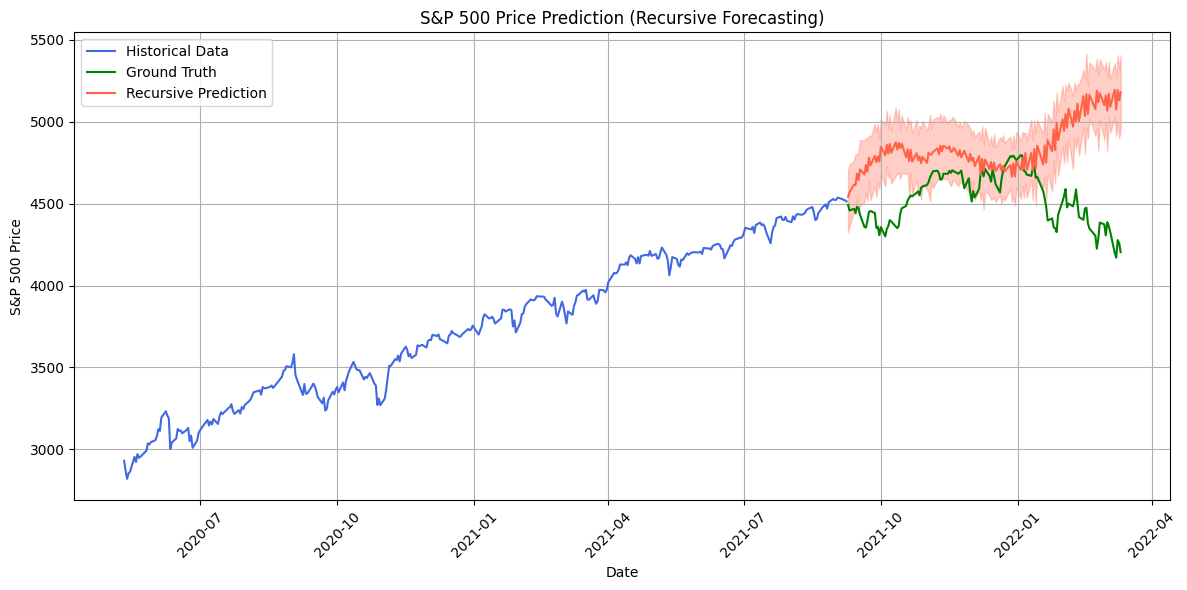

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily
from utils_snp.metrics import calculate_metrics

CONTEXT_WINDOW = 336
FORECAST_STEPS = 128  # Number of recursive forecasts to make

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.mps.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_single_forecast(context_data, start_date):
    """Generate a single one-step forecast"""
    context_data = np.asarray(context_data).flatten()
    
    dataset = ListDataset(
        [{"start": start_date, "target": context_data}],
        freq="1d"
    )
    
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=1,
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low[0], median[0], high[0]

def generate_recursive_forecasts(data, start_idx):
    """Recursive forecasting implementation"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    # Initialize with actual historical data
    context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].to_numpy()
    current_date = data['Date'].iloc[start_idx - CONTEXT_WINDOW]
    
    for i in range(FORECAST_STEPS):
        # Generate forecast
        low, median, high = generate_single_forecast(context_data, current_date)
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[start_idx + i])
        
        # Update context window: remove oldest, add prediction, advance date
        context_data = np.append(context_data[1:], median)
        current_date += pd.Timedelta(days=1)
        
        # Validation checks
        assert len(context_data) == CONTEXT_WINDOW, "Context window size changed"
        assert not np.isnan(median), "NaN value in prediction"
    
    return all_forecasts

def plot_forecast_with_recursive(data, start_idx, forecasts):
    """Visualization for recursive forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Plot historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Plot actual prices
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Plot recursive predictions
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label='Recursive Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction (Recursive Forecasting)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Select start index 
target_date = pd.Timestamp('2020-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Validate sufficient history
if start_idx < CONTEXT_WINDOW:
    raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history before target date")

# Generate recursive forecasts
forecasts = generate_recursive_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
metrics = calculate_metrics(actual_values, forecasts['median'], insample=None)

# Print metrics
print("\nRecursive Forecast Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot results
plot_forecast_with_recursive(sp500_d, start_idx, forecasts)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data_snp.snp500 import snp500_daily
from utils_snp.metrics import calculate_metrics

CONTEXT_WINDOW = 128
FORECAST_STEPS = 336  # Full prediction horizon

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.mps.is_available() else "cpu"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.mps.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    return list(forecast_it), list(ts_it)

def generate_direct_forecast(data, start_idx):
    """Enhanced direct multi-step forecast"""
    # Use full history up to start_idx
    context_data = data['Close'].iloc[:start_idx].values.flatten()
    context_start_date = data['Date'].iloc[0]  # Full history start
    
    # Create dataset with proper freq format
    dataset = ListDataset(
        [{"start": context_start_date, "target": context_data.astype(np.float32)}],
        freq="1d"  # Critical for GluonTS
    )
    
    # Match working code's prediction length
    prediction_length = 336  # From working example
    
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=prediction_length,
        context_length=len(context_data),  # Use full history
        use_rope_scaling=True,
        num_samples=100
    )
    
    forecast_samples = forecasts[0].samples
    low = np.percentile(forecast_samples, 10, axis=0)
    median = np.percentile(forecast_samples, 50, axis=0)
    high = np.percentile(forecast_samples, 90, axis=0)
    
    # Align with actual dates
    forecast_dates = data['Date'].iloc[start_idx:start_idx+prediction_length]
    
    return {
        'median': median,
        'low': low,
        'high': high,
        'dates': forecast_dates
    }

def plot_direct_forecast(data, start_idx, forecasts):
    """Visualization for direct multi-step forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual values
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Forecasts
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label='Direct Forecast')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'],
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(f'S&P 500 {FORECAST_STEPS}-Step Direct Forecast')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Select start index
target_date = pd.Timestamp('2023-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Validate sufficient history
if start_idx < CONTEXT_WINDOW:
    raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")

# Generate direct forecast
forecasts = generate_direct_forecast(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
metrics = calculate_metrics(actual_values, forecasts['median'], insample=None)

# Print metrics
print("\nDirect Multi-Step Forecast Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot results
plot_direct_forecast(sp500_d, start_idx, forecasts)

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_10132/2489901995.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

AssertionError: 